In [1]:
import h5py
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

import matplotlib.pyplot as plt

# Overview

Given a skewer of data ($\delta_{DM}^2$), we optimize for the underlying information ($\delta_{DM}$)

## Get the input and (fake) data

In [2]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"

h5 = h5py.File(filename,'r')

# take a skewer
shape = [1, 1, 1024]
inds = (0, 0, slice(0, shape[2]))

delta_true = h5['native_fields']['matter_density'][inds] # true DM density
y_true = np.exp(-delta_true)

h5.close()

In [ ]:
# plot the input
plt.figure(figsize=(10,4))
plt.plot(delta_true)
plt.title('delta_dm (true)')
plt.show()

In [ ]:
np.mean(np.log10(delta_true[delta_true > 0]))

In [6]:
# create starting point for optimization (random noise)
tf.random.set_seed(5)
log10_noise = tf.random.normal([shape[2]], 0, 0.5, tf.float32, seed=1)
delta_pred = 10**log10_noise

In [ ]:
# plot the log of input

plt.figure(figsize=(10,4))

plt.plot(np.log10(delta_true), label='log10(delta) (true)')
plt.plot(np.log10(delta_pred), label = 'log10(delta) (pred)')
plt.title('log10(delta)')

plt.legend()
plt.show()

## Optimization (attempt 1, doesn't work)

[TensorFlow Guide: Basic training loops](https://www.tensorflow.org/guide/basic_training_loops)

[Training and evaluating a model](https://www.tensorflow.org/guide/keras/train_and_evaluate/)

In [22]:
# mse = keras.losses.MeanSquaredError()

# def loss_fn(y_pred):
#     return mse(y_pred, y_true)

# class ToyModel(tf.keras.Model):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
        
#         # create starting point for optimization (random noise)
#         tf.random.set_seed(5)
#         log10_noise = tf.random.normal([shape[2]], 0, 0.5, tf.float32, seed=1)
#         self.delta = 10**log10_noise

#     def __call__(self, x):
#         return tf.square(self.delta)

# model = ToyModel()

# model.compile(
#     optimizer=keras.optimizers.SGD(),
#     loss=loss_fn
# )

# print("Fit model on training data")
# history = model.fit(
#     x=None,
#     y=None,
#     epochs=2
# )

## Optimization (attempt 2, works)

In [14]:
# example with tfp.math.minimize
x = tf.Variable(0.)
loss_fn = lambda: (x - 5.)**2
losses = tfp.math.minimize(loss_fn,
                           num_steps=100,
                           optimizer=tf.optimizers.Adam(learning_rate=0.1))

# In TF2/eager mode, the optimization runs immediately.
print("optimized value is {} with loss {}".format(x, losses[-1]))

optimized value is <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0390043> with loss 0.0014684273628517985


### Attempt with delta_dm

In [3]:
# create starting point for optimization (random noise)
tf.random.set_seed(5)
log10_noise = tf.random.normal([shape[2]], 0, 0.5, tf.float32, seed=1)
delta_pred = tf.Variable(10**log10_noise)

In [4]:
# model from input to data
def model(delta_pred):
    return tf.exp(-delta_pred)

# loss function
mse = keras.losses.MeanSquaredError()
loss_fn = lambda: mse(model(delta_pred), y_true)

# optimizer
optim = keras.optimizers.SGD(learning_rate=1e3)

print('Initial loss:', mse(model(delta_pred), y_true).numpy())

losses = tfp.math.minimize(loss_fn,
                           num_steps=5000,
                           optimizer=optim)

print('Final loss:', losses[-1].numpy())
print('delta_pred:\n', delta_pred)

Initial loss: 0.23679921
Final loss: 0.009067538
delta_pred:
 <tf.Variable 'Variable:0' shape=(1024,) dtype=float32, numpy=
array([ 1.16627775e-01,  2.15729833e-01, -1.13320357e-06, ...,
       -5.85683537e-08,  5.71279645e-01,  1.13848239e-01], dtype=float32)>


/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


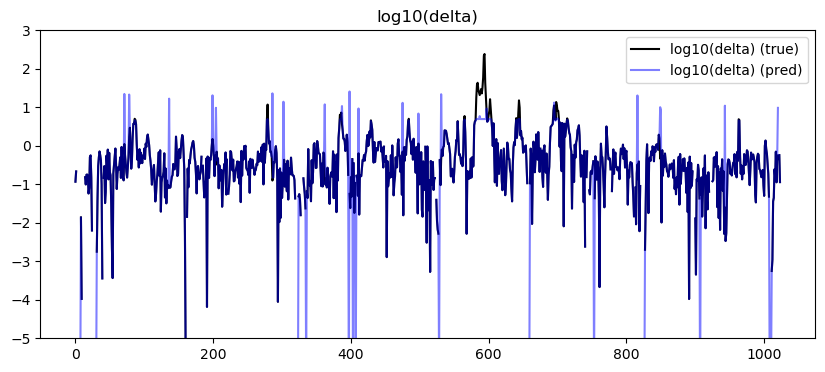

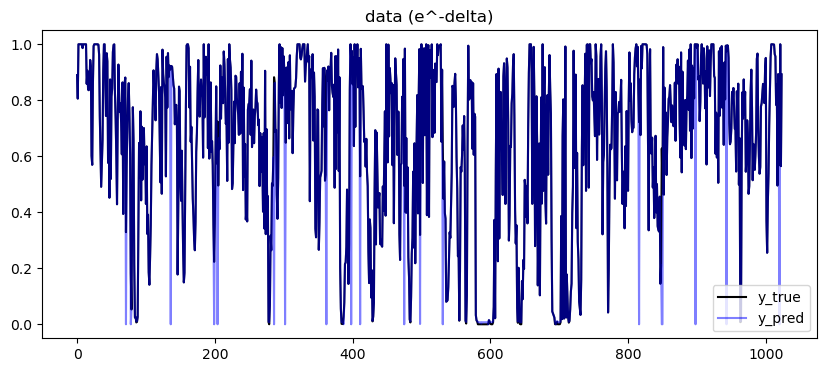

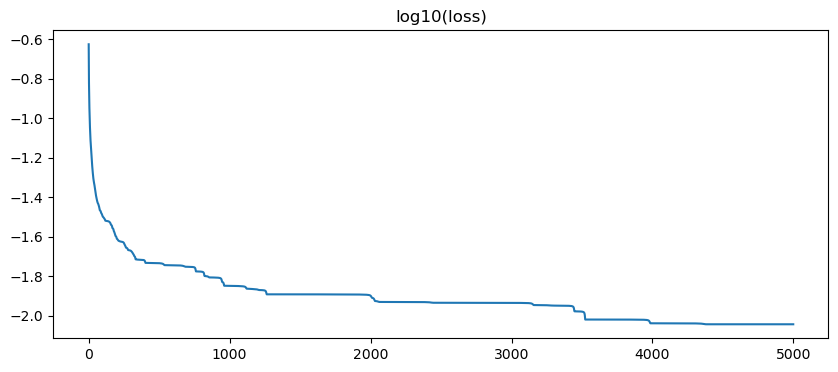

In [6]:
# true and predicted log(input)
plt.figure(figsize=(10,4))

plt.plot(np.log10(delta_true), color='black', label='log10(delta) (true)')
plt.plot(np.log10(delta_pred), 'blue', label = 'log10(delta) (pred)', alpha=0.5)
plt.title('log10(delta)')
plt.ylim(-5, 3)
plt.legend()
plt.show()

# true and predicted "data"
plt.figure(figsize=(10,4))
plt.plot(y_true, color='black', label='y_true')
plt.plot(model(delta_pred), 'blue', label = 'y_pred', alpha=0.5)
plt.title('data (e^-delta)')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(10,4))
plt.plot(np.log10(losses))
plt.title('log10(loss)')
plt.show()

In [25]:
# print relevant attributes (i.e. the metadata)
print("Format:", h5.attrs['format'])
print()

for key in h5['domain'].attrs.keys():
    print(key + ": " + str(h5['domain'].attrs[key]))
print()

for key in h5['universe'].attrs.keys():
    print(key + ": " + str(h5['universe'].attrs[key]))

Format: b'nyx-lyaf'

shape: [1024 1024 1024]
size: [21.09375 21.09375 21.09375]

hubble: 0.675
omega_b: 0.0487
omega_l: 0.69
omega_m: 0.31
redshift: 2.9999991588912964


In [8]:
# print the attribute keys of every group/dataset 
print(h5)
print(h5.attrs.keys())

def print_attrs(name, object):
    print(object)
    print(object.attrs.keys())
    
h5.visititems(print_attrs)

<HDF5 file "sim2_z3_FGPA_cgs.h5" (mode r)>
<KeysViewHDF5 ['format']>
<HDF5 group "/aux_fields" (3 members)>
<KeysViewHDF5 []>
<HDF5 dataset "DM_vx": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 []>
<HDF5 dataset "DM_vy": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 []>
<HDF5 dataset "DM_vz": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 []>
<HDF5 group "/derived_fields" (5 members)>
<KeysViewHDF5 []>
<HDF5 dataset "HI_number_density": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 ['units']>
<HDF5 dataset "flux_real": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 ['units']>
<HDF5 dataset "flux_red": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 ['units']>
<HDF5 dataset "tau_real": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 ['units']>
<HDF5 dataset "tau_red": shape (1024, 1024, 1024), type "<f4">
<KeysViewHDF5 ['units']>
<HDF5 group "/domain" (0 members)>
<KeysViewHDF5 ['shape', 'size']>
<HDF5 group "/native_fields" (9 members)>
<KeysViewHDF

In [31]:
# print the dataset names
for key in h5.keys():
    temp = h5[key]
    print(f'Datasets in {temp.name}: {list(temp.keys())}\n')

Datasets in /aux_fields: ['DM_vx', 'DM_vy', 'DM_vz']

Datasets in /derived_fields: ['HI_number_density', 'flux_real', 'flux_red', 'tau_real', 'tau_red']

Datasets in /domain: []

Datasets in /native_fields: ['baryon_density', 'matter_density', 'particle_vx', 'particle_vy', 'particle_vz', 'temperature', 'velocity_x', 'velocity_y', 'velocity_z']

Datasets in /universe: []



In [11]:
# print the units of every field
for field in h5['derived_fields']:
    print('Units of ' + field + ':', h5['derived_fields'][field].attrs['units'])
    
print()

for field in h5['native_fields']:
    print('Units of ' + field + ':', h5['native_fields'][field].attrs['units'])

Units of HI_number_density: b'cm**-3'
Units of flux_real: b'none'
Units of flux_red: b'none'
Units of tau_real: b'none'
Units of tau_red: b'none'

Units of baryon_density: b'(mean)'
Units of matter_density: b'(mean)'
Units of particle_vx: b'km/s'
Units of particle_vy: b'km/s'
Units of particle_vz: b'km/s'
Units of temperature: b'K'
Units of velocity_x: b'km/s'
Units of velocity_y: b'km/s'
Units of velocity_z: b'km/s'


In [12]:
h5.close()